# Further resolution tests with $\mathrm{Ra} = 10^9$

## Without hyperviscosity: model crashes at $t = 2.31 \times 10^6$

In [259]:
import xarray as xr
import numpy as np
import dedalus.public as d3
from IPython.display import Video
import matplotlib.pyplot as plt

import modules.math as math

In [37]:
Video('../data/restest_highRa_1024_128/restest_highRa_1024_128_s1.mp4')

This is probably not due to the time step, since $C < 1$ everywhere, except at the point where the model blows up:

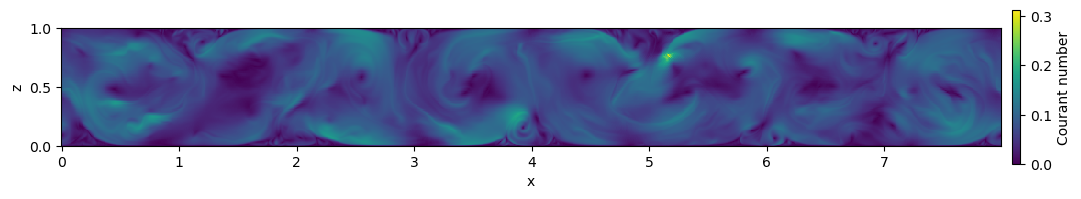

In [14]:
highRa = xr.open_mfdataset(
    '../data/restest_highRa_1024_128/*.nc', 
    chunks={'t': 1000, 'x': 128, 'z': 128})

def courant_number(data):
    diff_x = np.diff(data.x)
    dx = (
        np.concatenate([[diff_x[0]], diff_x])
        + np.concatenate([diff_x, [diff_x[-1]]])
    )/2
    diff_z = np.diff(data.z)
    dz = (
        np.concatenate([[diff_z[0]], diff_z])
        + np.concatenate([diff_z, [diff_z[-1]]])
    )/2
    C = np.sqrt(
        (np.abs(data.u)/np.atleast_2d(dx).T)**2
        + (np.abs(data.w)/np.atleast_2d(dz))**2
    )*data.timestep
    return C

fig, ax = plt.subplots(figsize=(12, 2), sharex=True)
mesh = ax.pcolormesh(
    highRa.x, highRa.z, courant_number(highRa.isel(t=769)).T, vmin=0)
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(aspect='equal', xlabel='x', ylabel='z')
fig.tight_layout()

Here is a close-up of the singularity:

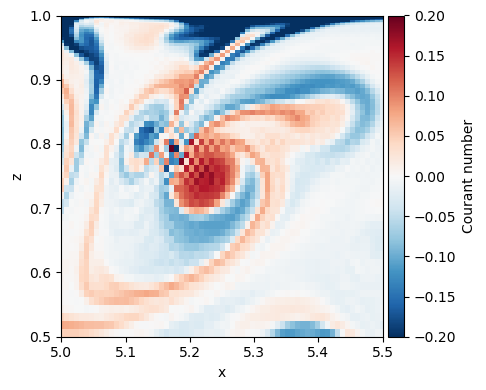

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
mesh = ax.pcolormesh(
    highRa.x, highRa.z, highRa.theta.isel(t=768).T,
    vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(
    aspect='equal', xlabel='x', ylabel='z', xlim=(5.0, 5.5), ylim=(0.5, 1.0))
fig.tight_layout()

## With hyperviscosity: model crashes at $t = 1.97 \times 10^6$
I now add 4th-order hyperviscosity terms $-\tilde{\nu} \nabla^4$ to the momentum and energy equations, choosing the hyperviscosity coefficient $\tilde{\nu} = 10^{-7}$. In order to avoid needing to specify additional boundary conditions, the hyperviscosity is reduced to zero at the boundaries using a factor $f(z) = 1 - (2z - 1)^{10}$. The equations in full are

$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} - \tilde{\nu} f(z) \nabla^4 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta - \tilde{\nu} f(z) \nabla^4 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$

In [19]:
Video('../data/restest_highRa_hyper/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.mp4')

Checking the data in coefficient space confirms that there is an accumulation of power in the high-wavenumber modes at the point that the model crashes:

In [201]:
data = xr.open_dataset('../data/restest_highRa_hyper/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.nc')

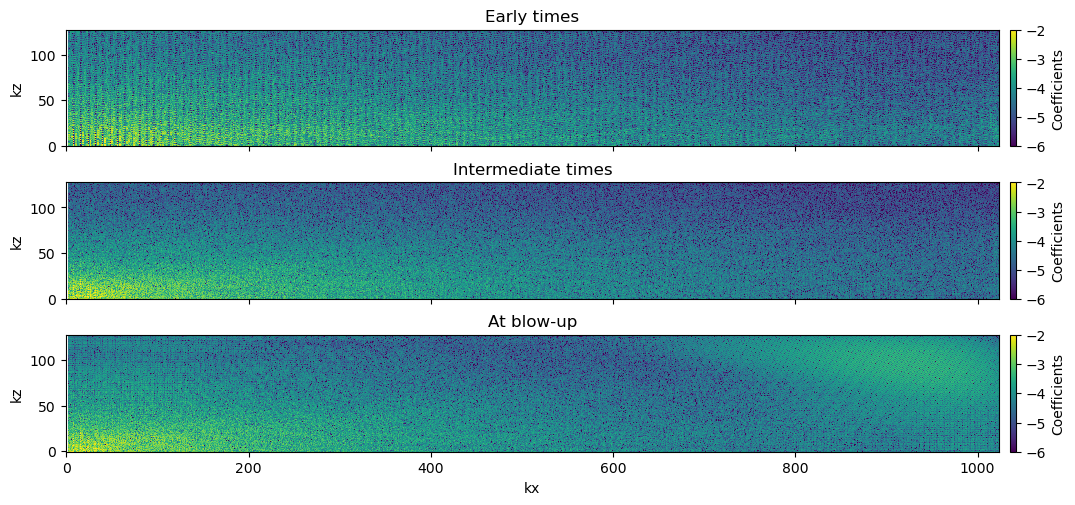

In [258]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

calculator = math.Math(1024, 128)

coef = calculator.space_coefficients(data.theta.isel(t=70))
mesh = axes[0].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[0], pad=0.01, label='Coefficients')
axes[0].set(aspect='equal', ylabel='kz', title='Early times')

coef = calculator.space_coefficients(data.theta.isel(t=600))
mesh = axes[1].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[1], pad=0.01, label='Coefficients')
axes[1].set(aspect='equal', ylabel='kz', title='Intermediate times')

coef = calculator.space_coefficients(data.theta.isel(t=656))
mesh = axes[2].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[2], pad=0.01, label='Coefficients')
axes[2].set(aspect='equal', xlabel='kx', ylabel='kz', title='At blow-up')

fig.tight_layout()


### Checking the magnitude of each term in the equations
To gain insight into the failure of the hyperviscosity, I now calculate and plot each term contributing to $\partial_t u$, $\partial_t w$ and $\partial_t \theta$.

#### At early times

In [234]:
i_time = 70
Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

calculator = math.Math(1024, 128)

u = calculator.array_to_field(data.u.isel(t=i_time))
w = calculator.array_to_field(data.w.isel(t=i_time))
theta = calculator.array_to_field(data.theta.isel(t=i_time))

taper = calculator.dist.Field(name='taper', bases=calculator.zbasis)
taper['g'] = 1 - (2*calculator.z - 1)**10

u_terms = {
    'advection': (
        u * d3.Differentiate(u, calculator.coords['x'])
        + w * d3.Differentiate(u, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(u)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(u))
    )*Prandtl/Rayleigh
}
w_terms = {
    'advection': (
        u * d3.Differentiate(w, calculator.coords['x'])
        + w * d3.Differentiate(w, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(w)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(w))
    )*Prandtl/Rayleigh,
    'buoyancy': theta*Prandtl/Rayleigh
}
theta_terms = {
    'advection': (
        u * d3.Differentiate(theta, calculator.coords['x'])
        + w * d3.Differentiate(theta, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(theta)/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(theta))
    )/Rayleigh
}

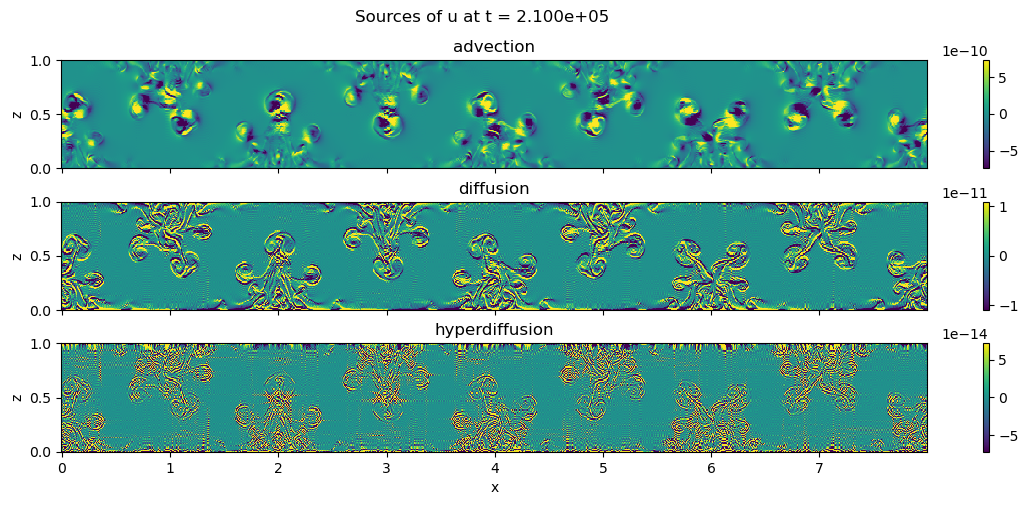

In [226]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

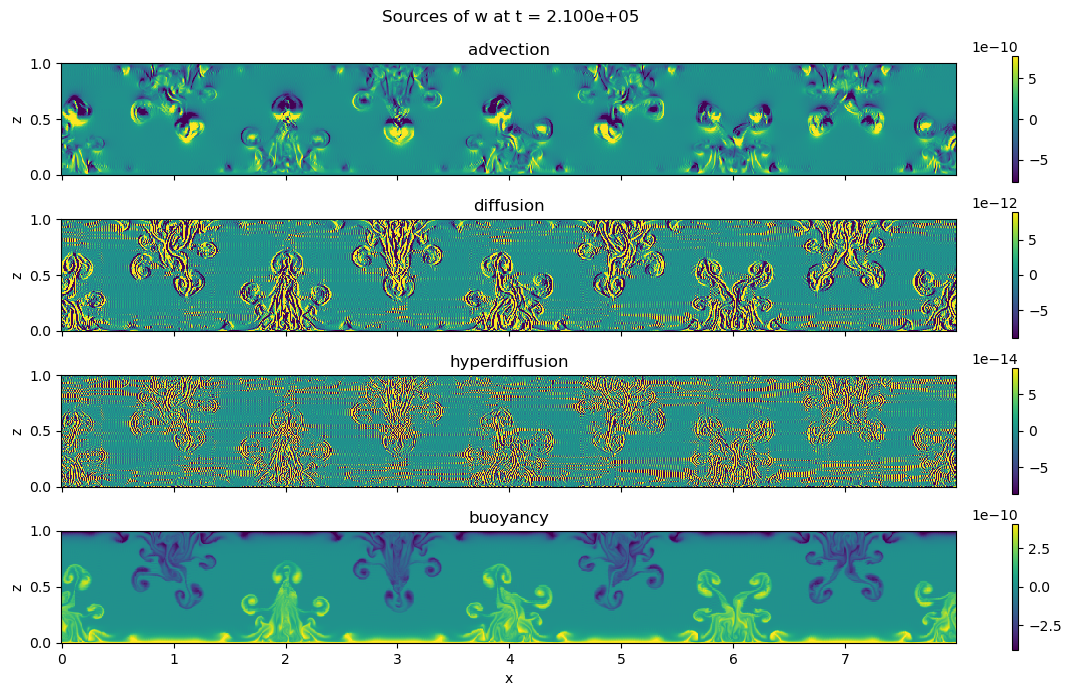

In [235]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

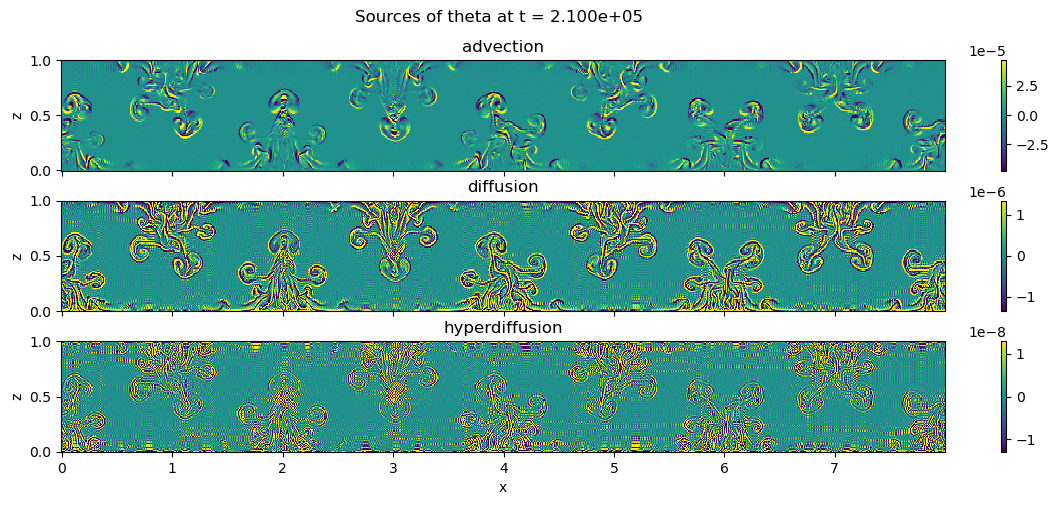

In [228]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### At intermediate times

In [244]:
i_time = 600
Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

calculator = math.Math(1024, 128)

u = calculator.array_to_field(data.u.isel(t=i_time))
w = calculator.array_to_field(data.w.isel(t=i_time))
theta = calculator.array_to_field(data.theta.isel(t=i_time))

taper = calculator.dist.Field(name='taper', bases=calculator.zbasis)
taper['g'] = 1 - (2*calculator.z - 1)**10

u_terms = {
    'advection': (
        u * d3.Differentiate(u, calculator.coords['x'])
        + w * d3.Differentiate(u, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(u)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(u))
    )*Prandtl/Rayleigh
}
w_terms = {
    'advection': (
        u * d3.Differentiate(w, calculator.coords['x'])
        + w * d3.Differentiate(w, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(w)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(w))
    )*Prandtl/Rayleigh,
    'buoyancy': theta*Prandtl/Rayleigh
}
theta_terms = {
    'advection': (
        u * d3.Differentiate(theta, calculator.coords['x'])
        + w * d3.Differentiate(theta, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(theta)/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(theta))
    )/Rayleigh
}

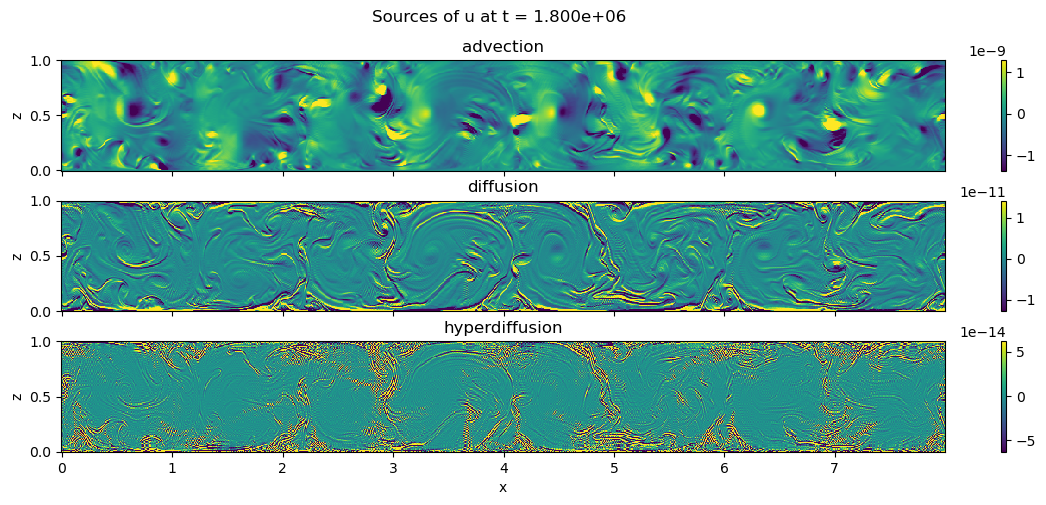

In [245]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

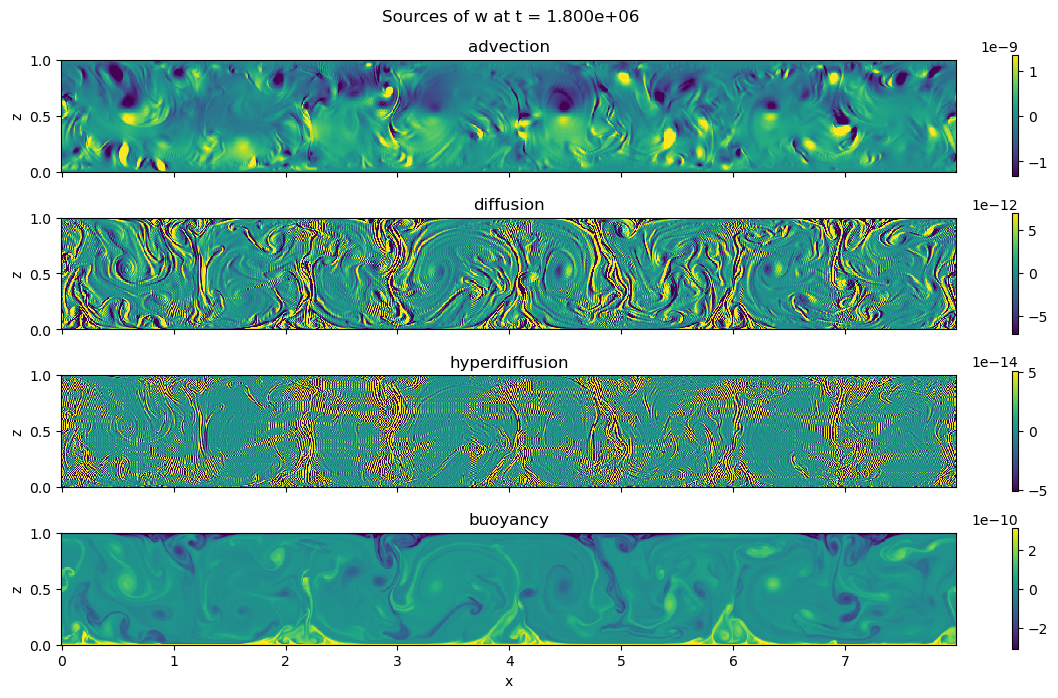

In [246]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

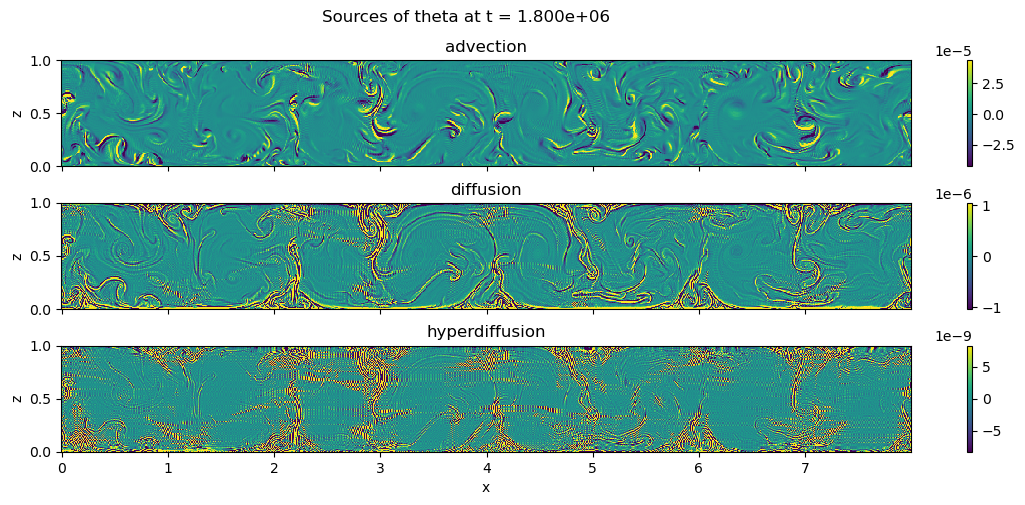

In [247]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### At blow-up

In [252]:
i_time = 653
Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

calculator = math.Math(1024, 128)

u = calculator.array_to_field(data.u.isel(t=i_time))
w = calculator.array_to_field(data.w.isel(t=i_time))
theta = calculator.array_to_field(data.theta.isel(t=i_time))

taper = calculator.dist.Field(name='taper', bases=calculator.zbasis)
taper['g'] = 1 - (2*calculator.z - 1)**10

u_terms = {
    'advection': (
        u * d3.Differentiate(u, calculator.coords['x'])
        + w * d3.Differentiate(u, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(u)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(u))
    )*Prandtl/Rayleigh
}
w_terms = {
    'advection': (
        u * d3.Differentiate(w, calculator.coords['x'])
        + w * d3.Differentiate(w, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(w)*Prandtl/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(w))
    )*Prandtl/Rayleigh,
    'buoyancy': theta*Prandtl/Rayleigh
}
theta_terms = {
    'advection': (
        u * d3.Differentiate(theta, calculator.coords['x'])
        + w * d3.Differentiate(theta, calculator.coords['z'])
    ),
    'diffusion': d3.Laplacian(theta)/Rayleigh,
    'hyperdiffusion': (
        hyper * taper * d3.Laplacian(d3.Laplacian(theta))
    )/Rayleigh
}

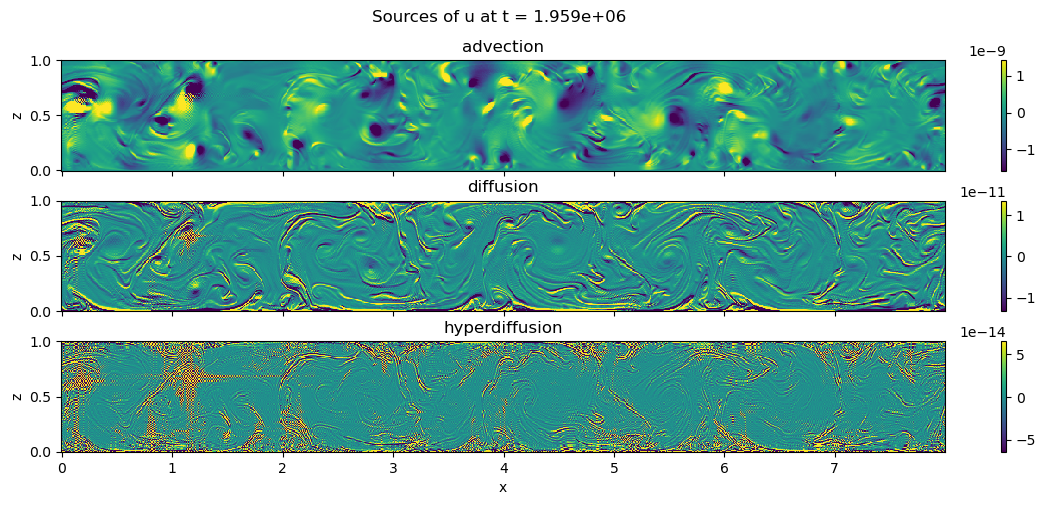

In [253]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

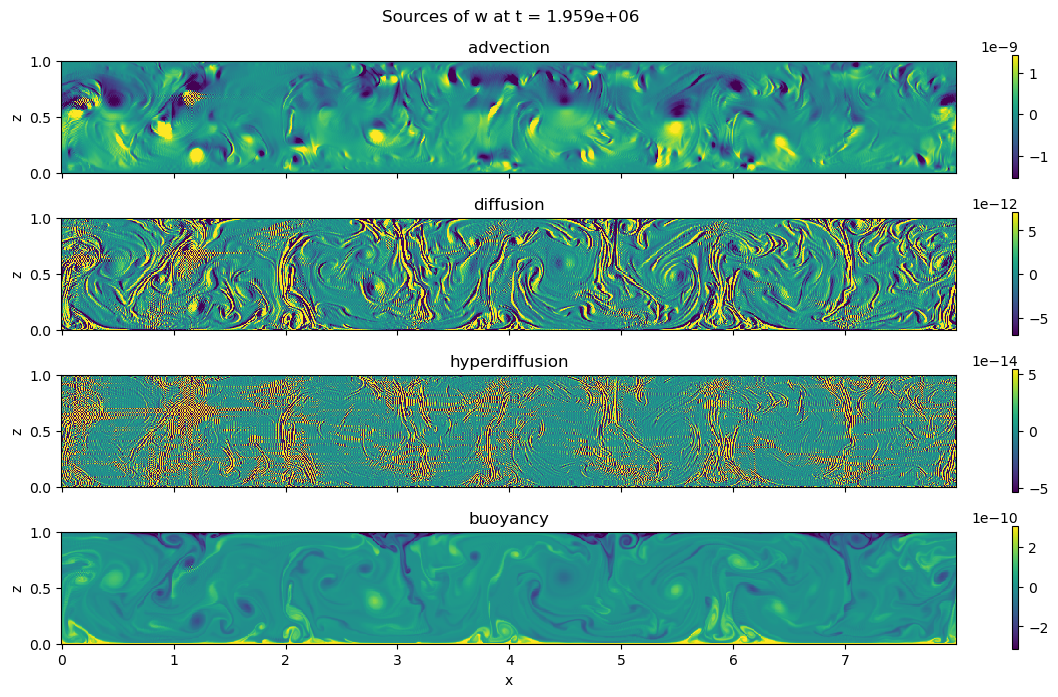

In [254]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

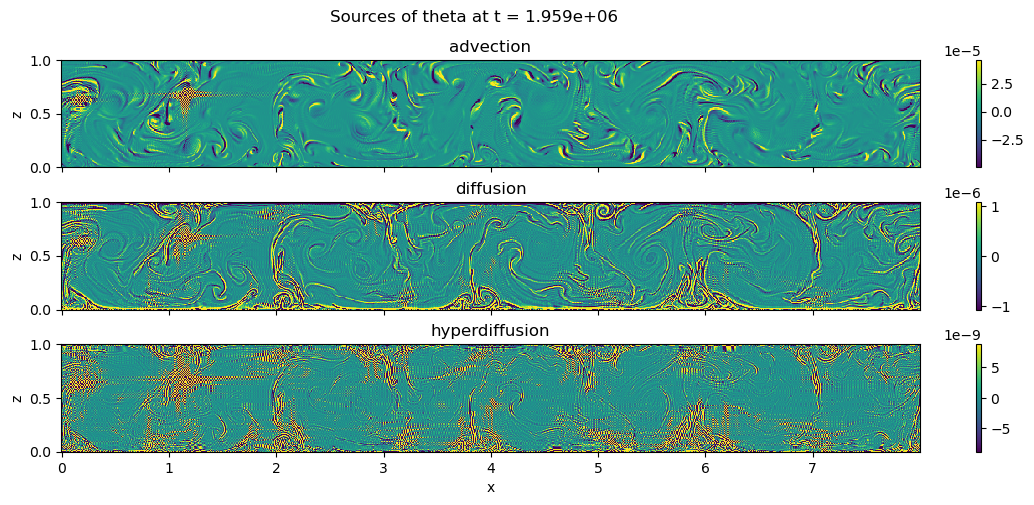

In [255]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].evaluate()
    array.change_scales(1)
    array = array['g']
    mesh = axes[i].pcolormesh(
        calculator.x.squeeze(), calculator.z.squeeze(), array.T)
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### Conclusion

Evidently, although the variables themselves are reasonably well-resolved, the spatial resolution is insufficient to accurately resolve their derivatives. This leads to widespread artefacts in all the derivative terms. The hyperdiffusion is the worst-affected, because it involved the highest derivative order (4). It is therefore hardly surprising that these artefacts eventually cause the model to crash. It seems reasonable to assume that the hyperdiffusion is not working because the fourth derivatives are not being accurately represented.